In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-prediction-dataset/Churn_Modelling.csv


###  Bank Customer Churn Analysis
#### This notebook analyzes customer churn data from a bank to understand patterns and prepare data for predictive modeling.

### 1. Import Required Libraries


In [2]:
# 1. Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc,precision_recall_curve
from tensorflow.keras import layers, models, Input
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler


### 2. Load and Examine the Data


In [3]:
df = pd.read_csv("/kaggle/input/bank-customer-churn-prediction-dataset/Churn_Modelling.csv")


In [4]:
# check for missing values
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [5]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows of the dataset:")
display(df.head())

print("\nDataset Info:")
display(df.info())

print("\nBasic Statistics:")
display(df.describe())

Dataset Shape: (10000, 14)

First few rows of the dataset:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


None


Basic Statistics:


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


### 3. Data Exploration and Visualization

#### 3.1 Churn Distribution

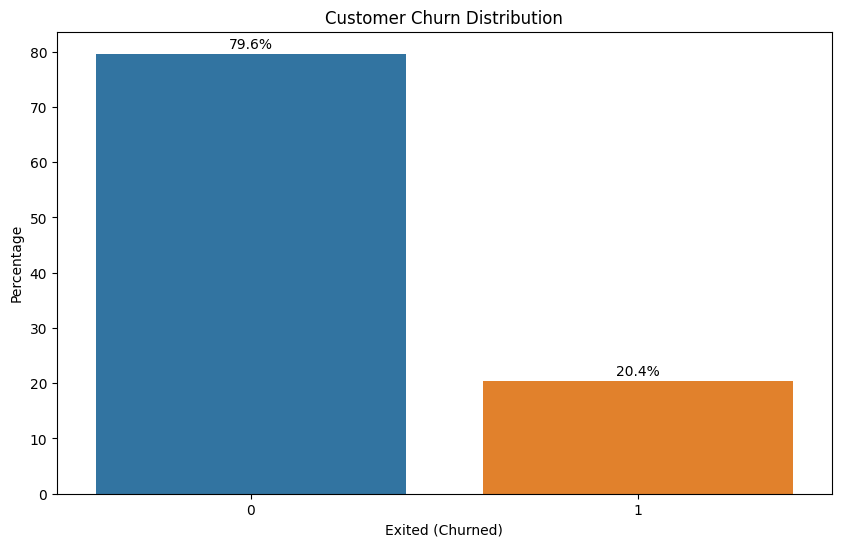

In [6]:
plt.figure(figsize=(10, 6))
churn_dist = df['Exited'].value_counts(normalize=True) * 100
sns.barplot(x=churn_dist.index, y=churn_dist.values)
plt.title('Customer Churn Distribution')
plt.xlabel('Exited (Churned)')
plt.ylabel('Percentage')
for i, v in enumerate(churn_dist.values):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center')
plt.show()

#### 3.2 Demographic Analysis

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


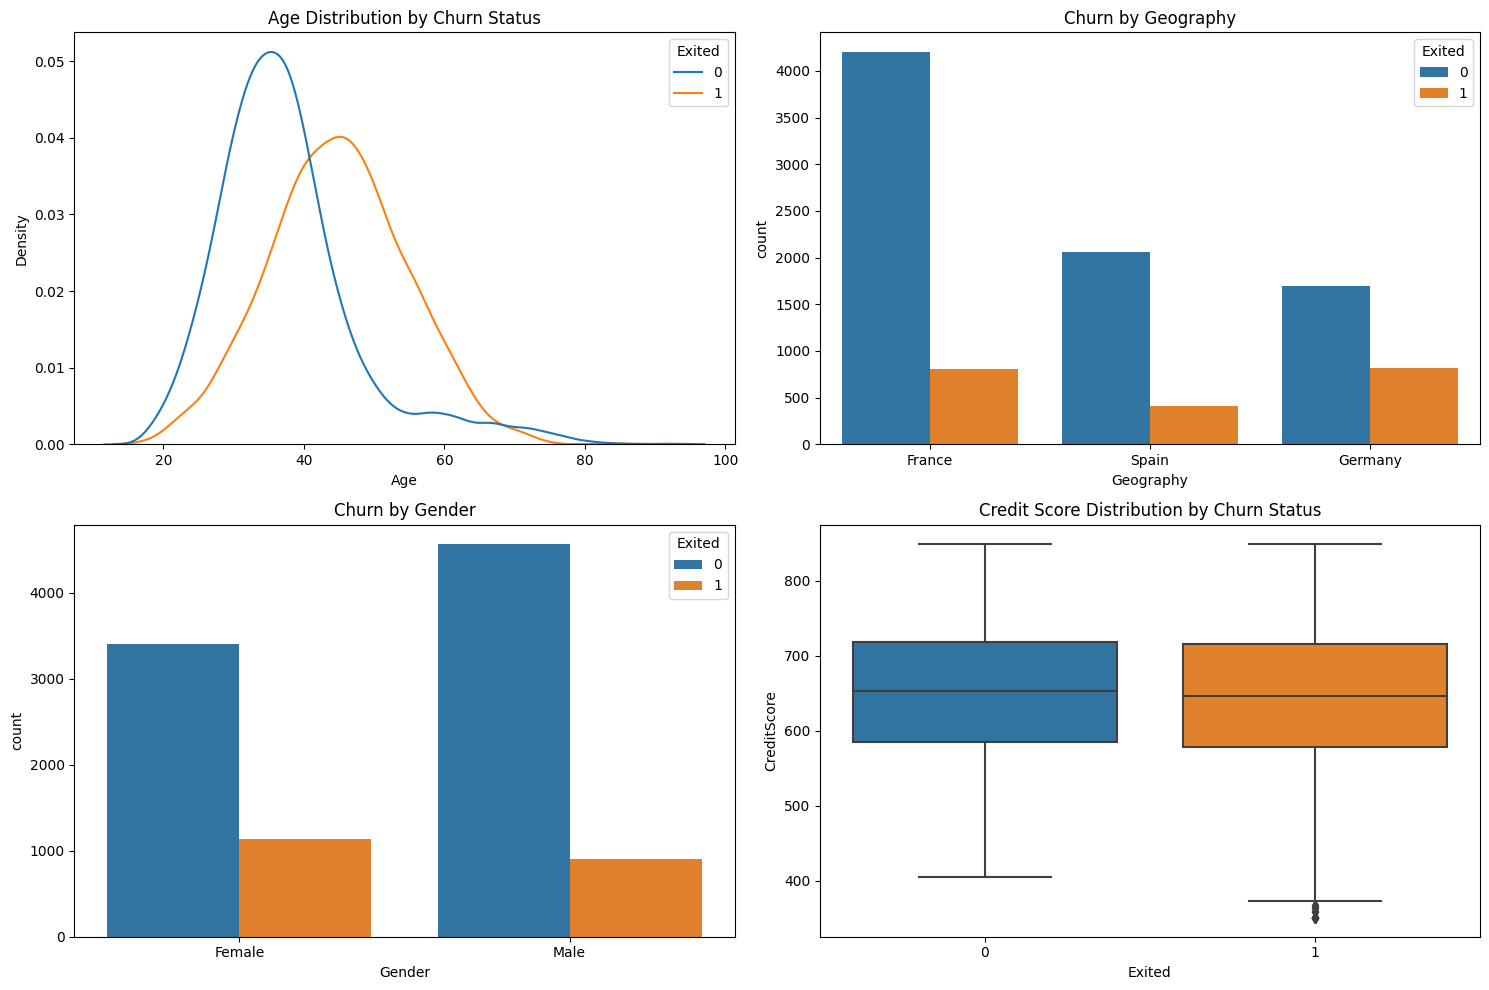

In [7]:
# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))

# Age Distribution
plt.subplot(2, 2, 1)
sns.kdeplot(data=df, x='Age', hue='Exited', common_norm=False)
plt.title('Age Distribution by Churn Status')

# Geography Distribution
plt.subplot(2, 2, 2)
sns.countplot(data=df, x='Geography', hue='Exited')
plt.title('Churn by Geography')

# Gender Distribution
plt.subplot(2, 2, 3)
sns.countplot(data=df, x='Gender', hue='Exited')
plt.title('Churn by Gender')

# Credit Score Distribution
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='Exited', y='CreditScore')
plt.title('Credit Score Distribution by Churn Status')

plt.tight_layout()
plt.show()


#### 3.3 Financial Metrics Analysis

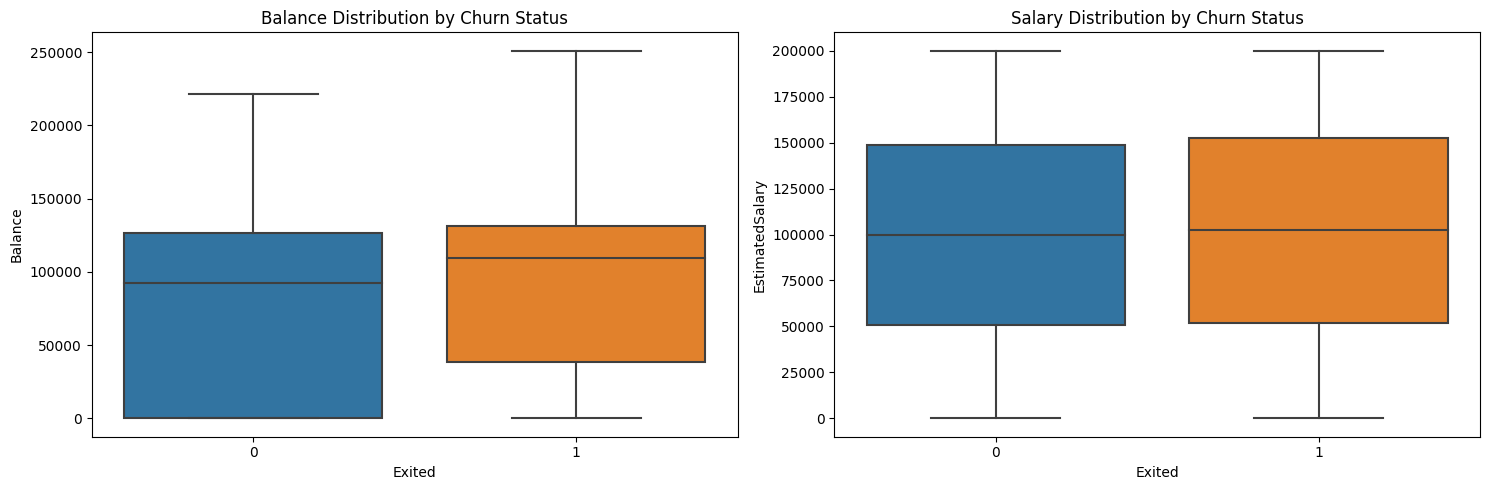

In [8]:
plt.figure(figsize=(15, 5))

# Balance Distribution
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='Exited', y='Balance')
plt.title('Balance Distribution by Churn Status')

# Estimated Salary Distribution
plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='Exited', y='EstimatedSalary')
plt.title('Salary Distribution by Churn Status')

plt.tight_layout()
plt.show()

#### 3.4 Product Related Analysis


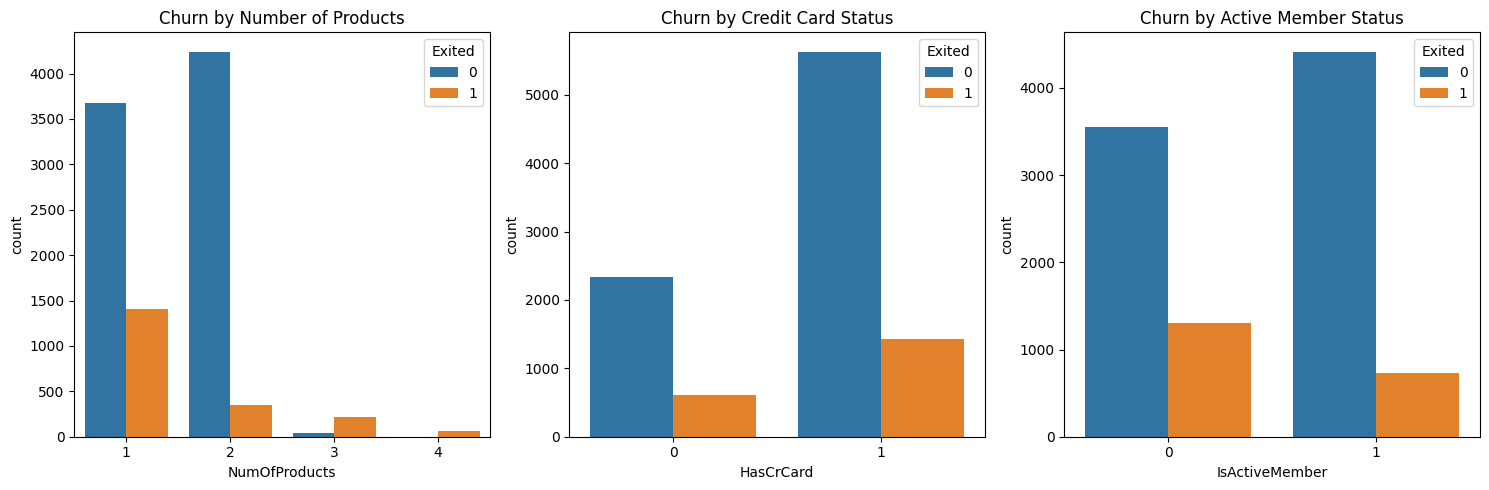

In [9]:
plt.figure(figsize=(15, 5))

# Number of Products
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='NumOfProducts', hue='Exited')
plt.title('Churn by Number of Products')

# Credit Card Status
plt.subplot(1, 3, 2)
sns.countplot(data=df, x='HasCrCard', hue='Exited')
plt.title('Churn by Credit Card Status')

# Active Member Status
plt.subplot(1, 3, 3)
sns.countplot(data=df, x='IsActiveMember', hue='Exited')
plt.title('Churn by Active Member Status')

plt.tight_layout()
plt.show()


#### 3.5 Correlation Analysis


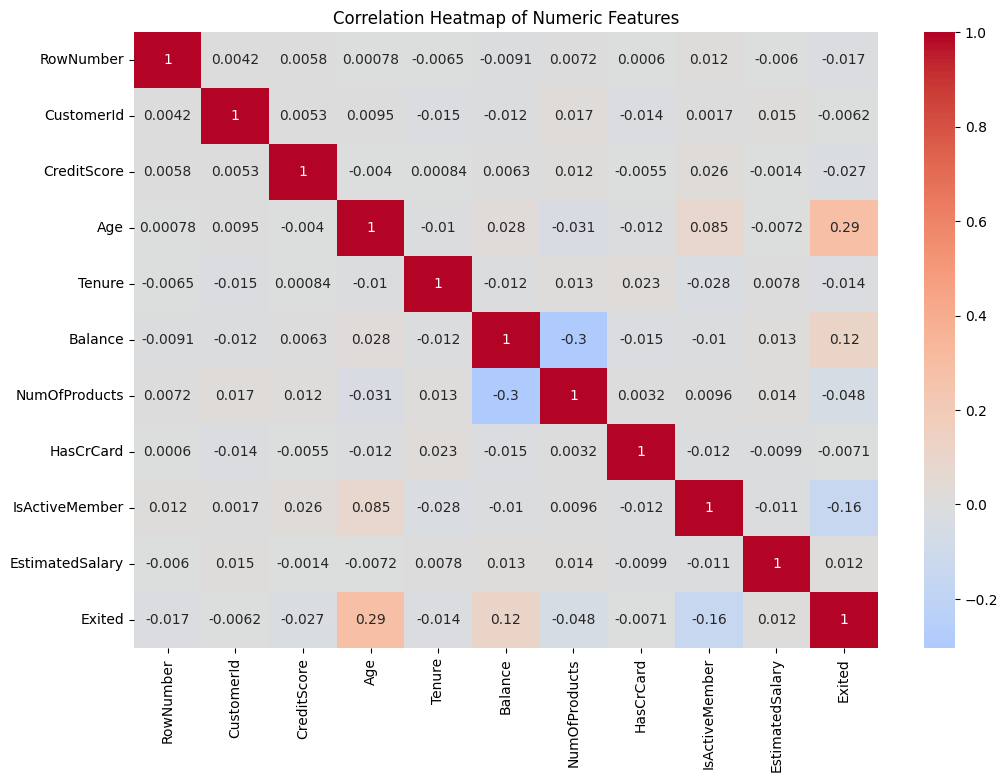

In [10]:
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

### 4. Data Preprocessing

#### 4.1 Remove Unnecessary Columns


In [11]:
df_processed = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

#### 4.2 Encode Categorical Variables


In [12]:
le = LabelEncoder()
df_processed['Gender'] = le.fit_transform(df_processed['Gender'])
df_processed['Geography'] = le.fit_transform(df_processed['Geography'])

#### 4.3 Scale Numerical Features


In [13]:
scaler = StandardScaler()
numerical_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])

In [14]:
# Display processed dataset
print("Processed Dataset Preview:")
display(df_processed.head())

Processed Dataset Preview:


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.326221,0,0,0.293517,-1.041760,-1.225848,1,1,1,0.021886,1
1,-0.440036,2,0,0.198164,-1.387538,0.117350,1,0,1,0.216534,0
2,-1.536794,0,0,0.293517,1.032908,1.333053,3,1,0,0.240687,1
3,0.501521,0,0,0.007457,-1.387538,-1.225848,2,0,0,-0.108918,0
4,2.063884,2,0,0.388871,-1.041760,0.785728,1,1,1,-0.365276,0


#### 4.4 Split the Data


In [15]:
X = df_processed.drop('Exited', axis=1)
y = df_processed['Exited']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("\nData Split Shapes:")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Data Split Shapes:
Training set shape: (8000, 10)
Testing set shape: (2000, 10)


#### 4.5 Create feature interactions


In [16]:
print("Creating feature interactions...")
X_train['age_balance'] = X_train['Age'] * X_train['Balance']
X_train['tenure_products'] = X_train['Tenure'] * X_train['NumOfProducts']
X_test['age_balance'] = X_test['Age'] * X_test['Balance']
X_test['tenure_products'] = X_test['Tenure'] * X_test['NumOfProducts']

Creating feature interactions...


#### 4.6 Scale features


In [17]:
print("Scaling features...")
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

Scaling features...


#### 4.7 Apply SMOTE for class balancing


In [18]:
# Step 3: Apply SMOTE for class balancing
print("Applying SMOTE for class balancing...")
smote_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
])
X_train_balanced, y_train_balanced = smote_pipeline.fit_resample(X_train_scaled, y_train)

Applying SMOTE for class balancing...


###  5. The model

#### 5.1 Data Preparation

In [19]:
print("Preparing TensorFlow datasets...")
train_data_balanced = X_train_balanced.copy()
train_data_balanced['target'] = y_train_balanced
test_data_scaled = X_test_scaled.copy()
test_data_scaled['target'] = y_test

# Create TF datasets
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data_balanced, label='target')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data_scaled, label='target')

# Initialize empty results list
results = []

Preparing TensorFlow datasets...


#### 5.2  Neural Network Model Architecture

In [20]:
def create_neural_network(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

#### 5.3 Initialize Models

In [21]:
print("Initializing models...")
neural_network = create_neural_network((X_train_balanced.shape[1],))
random_forest = tfdf.keras.RandomForestModel()
svm = SVC(kernel='rbf', probability=True, random_state=42)

Initializing models...
Use /tmp/tmp5ym3cw5p as temporary training directory


#### 5.4 Evaluation Function

In [22]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """
    Evaluate model performance with multiple metrics including AUPRC
    """
    # Convert predictions to binary if needed
    if len(y_pred.shape) > 1:
        y_pred_binary = (y_pred > 0.5).astype(int).ravel()
        y_pred_proba = y_pred_proba.ravel()
    else:
        y_pred_binary = y_pred
        
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Calculate Precision-Recall curve and AUPRC
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    auprc = auc(recall, precision)
    
    print(f"\n=== {model_name} Performance ===")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"F1 Score: {f1:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print(f"AUPRC: {auprc:.3f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_binary))
    
    # Plot metrics
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_binary)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title(f'Confusion Matrix - {model_name}')
    ax1.set_ylabel('True Label')
    ax1.set_xlabel('Predicted Label')
    
    # ROC Curve
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve')
    ax2.legend(loc="lower right")
    
    # Precision-Recall Curve
    ax3.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUPRC = {auprc:.3f})')
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve')
    ax3.legend(loc="lower left")
    
    # Prediction Distribution
    ax4.hist(y_pred_proba[y_true == 0], bins=50, alpha=0.5, label='Non-Churn', density=True)
    ax4.hist(y_pred_proba[y_true == 1], bins=50, alpha=0.5, label='Churn', density=True)
    ax4.set_title('Prediction Distribution')
    ax4.set_xlabel('Predicted Probability')
    ax4.set_ylabel('Density')
    ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'roc_auc': roc_auc,
        'auprc': auprc
    }

#### 5.5 Neural Network Training and Evaluation


Training Neural Network...
Epoch 1/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6581 - loss: 0.6463 - val_accuracy: 0.4733 - val_loss: 0.8390
Epoch 2/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7522 - loss: 0.4998 - val_accuracy: 0.6146 - val_loss: 0.6695
Epoch 3/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7721 - loss: 0.4732 - val_accuracy: 0.6880 - val_loss: 0.6131
Epoch 4/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7730 - loss: 0.4691 - val_accuracy: 0.7076 - val_loss: 0.5622
Epoch 5/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7904 - loss: 0.4567 - val_accuracy: 0.7088 - val_loss: 0.5632
Epoch 6/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7889 - loss: 0.4461 - val_accuracy: 0.7394 - val_loss: 0.5205
Epoch 7/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8004 - loss: 0.4372 - val_accuracy: 0.7131 - val_loss: 0.5598
Epoch 8/100
319/319 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.79

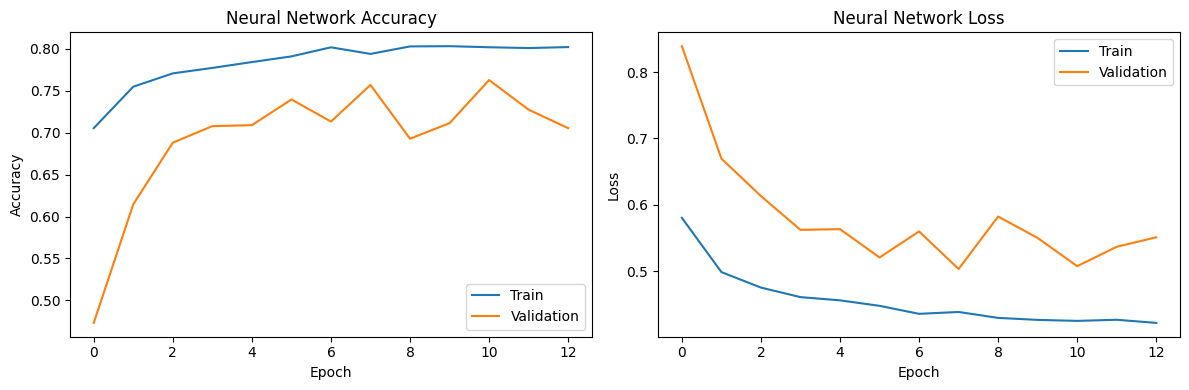

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

=== Neural Network Performance ===
Accuracy: 0.827
F1 Score: 0.606
ROC AUC: 0.843
AUPRC: 0.679

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1593
           1       0.56      0.66      0.61       407

    accuracy                           0.83      2000
   macro avg       0.74      0.76      0.75      2000
weighted avg       0.84      0.83      0.83      2000



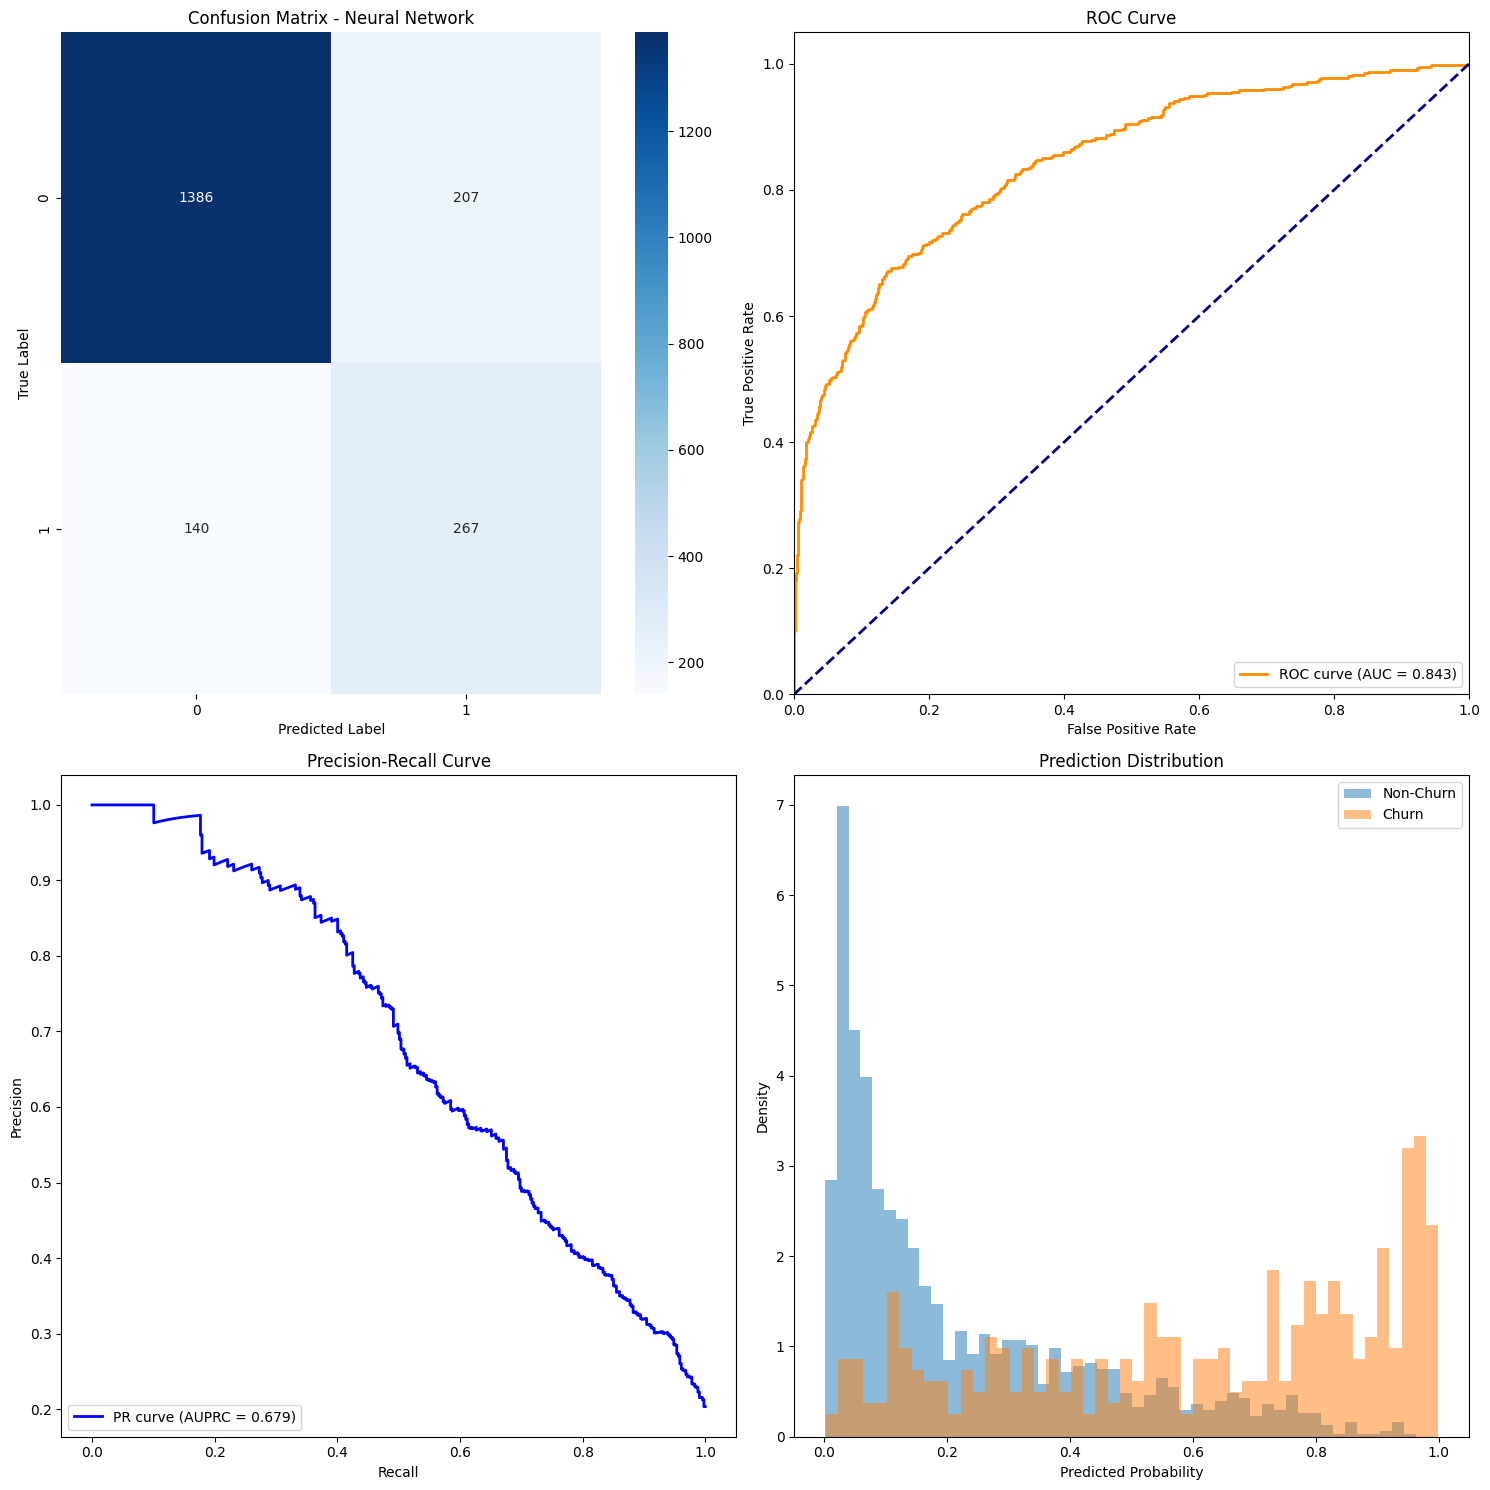

In [23]:
print("\nTraining Neural Network...")
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = neural_network.fit(
    X_train_balanced, y_train_balanced,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Neural Network Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Neural Network Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

# Evaluate Neural Network
y_pred_nn = neural_network.predict(X_test_scaled)
nn_metrics = evaluate_model(y_test, y_pred_nn, y_pred_nn, "Neural Network")
results.append({
    'Model': 'Neural Network',
    **nn_metrics
})

#### 5.6 Random Forest and SVM Training


Training Random Forest...
Reading training dataset...
Training dataset read in 0:00:04.962017. Found 12740 examples.
Training model...


[INFO 24-12-01 04:57:32.1093 UTC kernel.cc:1233] Loading model from path /tmp/tmp5ym3cw5p/model/ with prefix c6a0c8c4efcb4342


Model trained in 0:00:07.605838
Compiling model...


[INFO 24-12-01 04:57:33.8127 UTC decision_forest.cc:734] Model loaded with 300 root(s), 379152 node(s), and 12 input feature(s).
[INFO 24-12-01 04:57:33.8128 UTC abstract_model.cc:1362] Engine "RandomForestOptPred" built
[INFO 24-12-01 04:57:33.8128 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 46ms/step

=== Random Forest Performance ===
Accuracy: 0.849
F1 Score: 0.626
ROC AUC: 0.848
AUPRC: 0.671

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1593
           1       0.63      0.62      0.63       407

    accuracy                           0.85      2000
   macro avg       0.77      0.76      0.77      2000
weighted avg       0.85      0.85      0.85      2000



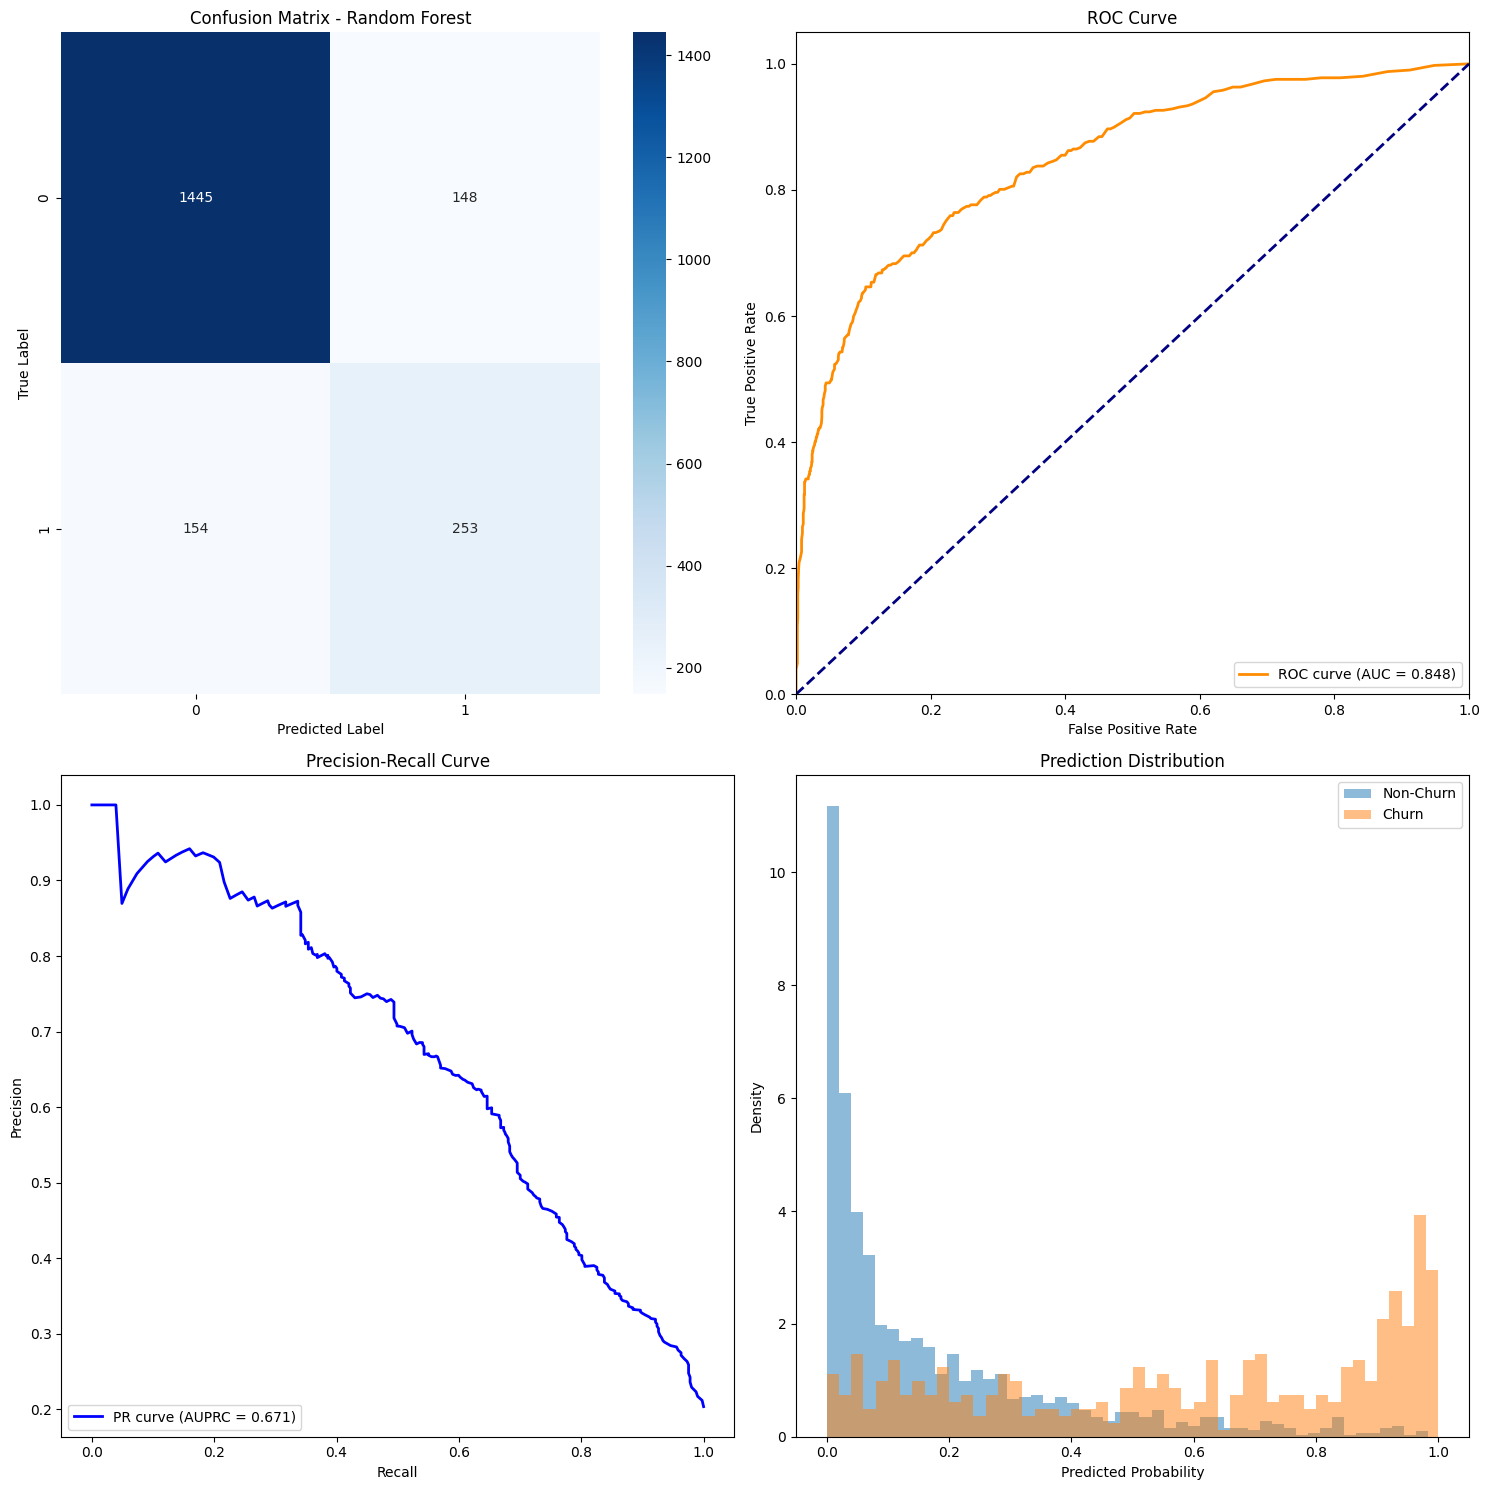

In [24]:
# Train Random Forest
print("\nTraining Random Forest...")
random_forest.fit(train_ds)
y_pred_rf = random_forest.predict(test_ds)
rf_metrics = evaluate_model(y_test, y_pred_rf, y_pred_rf, "Random Forest")
results.append({
    'Model': 'Random Forest',
    **rf_metrics
})


Training SVM...

=== SVM Performance ===
Accuracy: 0.787
F1 Score: 0.581
ROC AUC: 0.829
AUPRC: 0.629

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      1593
           1       0.48      0.72      0.58       407

    accuracy                           0.79      2000
   macro avg       0.70      0.76      0.72      2000
weighted avg       0.83      0.79      0.80      2000



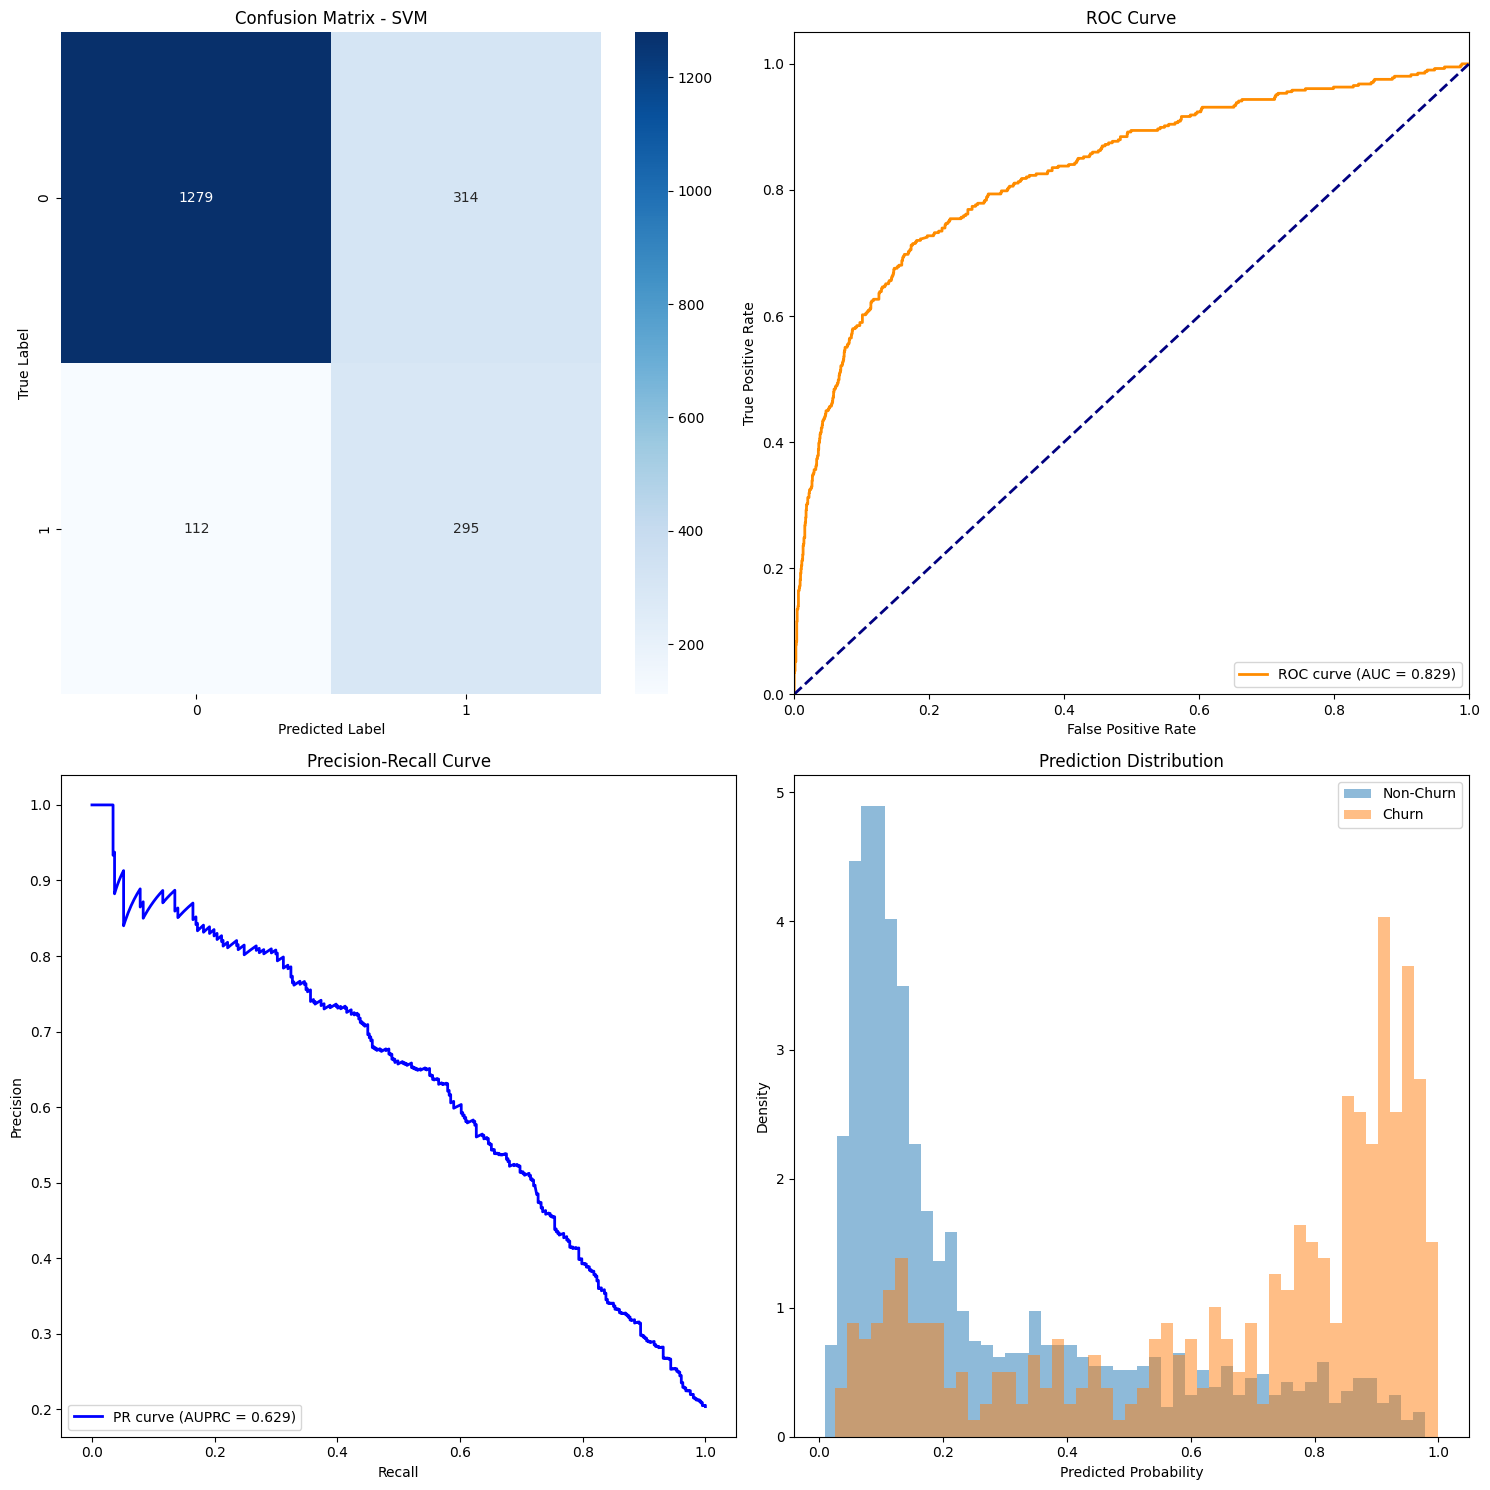

In [25]:
# Train SVM
print("\nTraining SVM...")
svm.fit(X_train_balanced, y_train_balanced)
y_pred_svm = svm.predict(X_test_scaled)
y_pred_svm_proba = svm.predict_proba(X_test_scaled)[:, 1]
svm_metrics = evaluate_model(y_test, y_pred_svm, y_pred_svm_proba, "SVM")
results.append({
    'Model': 'SVM',
    **svm_metrics
})


#### 5.7 Model Comparison and Visualization


Model Comparison:
         Model  accuracy       f1  roc_auc    auprc
Neural Network    0.8265 0.606129 0.843164 0.679286
 Random Forest    0.8490 0.626238 0.847522 0.670577
           SVM    0.7870 0.580709 0.828723 0.628656


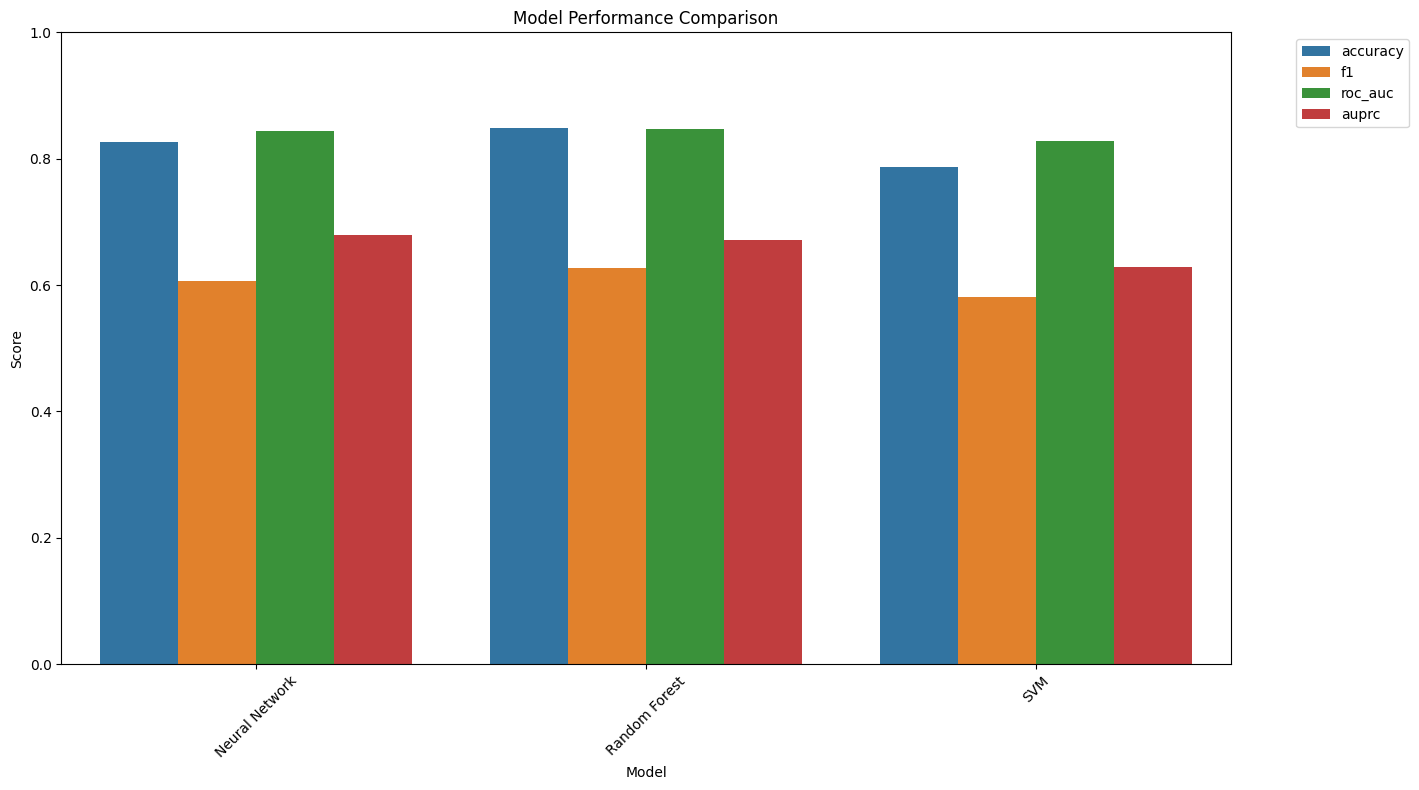


Best Models:
Best accuracy: Random Forest (0.849)
Best f1: Random Forest (0.626)
Best roc_auc: Random Forest (0.848)
Best auprc: Neural Network (0.679)

Best Model (by F1 Score): Random Forest
Metrics for best model:
accuracy: 0.849
f1: 0.626
roc_auc: 0.848
auprc: 0.671


In [26]:
comparison_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Modified comparison visualization
plt.figure(figsize=(15, 8))  # Increased figure size
comparison_melted = comparison_df.melt(
    id_vars=['Model'], 
    value_vars=['accuracy', 'f1', 'roc_auc', 'auprc'],
    var_name='Metric',
    value_name='Score'
)

# Create the plot with adjusted layout
g = sns.barplot(data=comparison_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)

# Move legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout with more space
plt.subplots_adjust(right=0.85)  # Make room for legend
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Adjust the rect parameter



plt.show()

# Find best model for each metric
metrics = ['accuracy', 'f1', 'roc_auc', 'auprc']
print("\nBest Models:")
for metric in metrics:
    idx = comparison_df[metric].idxmax()
    print(f"Best {metric}: {comparison_df.loc[idx, 'Model']} "
          f"({comparison_df.loc[idx, metric]:.3f})")

# If you want to choose based on F1 score specifically
best_f1_idx = comparison_df['f1'].idxmax()
best_model = comparison_df.loc[best_f1_idx]
print(f"\nBest Model (by F1 Score): {best_model['Model']}")
print(f"Metrics for best model:")
for metric in metrics:
    print(f"{metric}: {best_model[metric]:.3f}")

### 6 Improve The Models

#### 6.1 Deep Neural Network 

In [27]:
def create_improved_neural_network(input_shape):
    inputs = Input(shape=input_shape)
    
    # Wider network
    x = layers.Dense(512, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    
    # Add residual connections
    x_skip = x
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, x_skip])

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Dense(64, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(32, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    
    # Use learning rate scheduling
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9
    )
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )
    
    return model

#### 6.2 Train & Evaluate The Deep Neural Network 


Training Deep Neural Network...
Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6587 - auc: 0.6618 - loss: 0.6531 - val_accuracy: 0.7975 - val_auc: 0.7288 - val_loss: 0.4718
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8101 - auc: 0.7881 - loss: 0.4400 - val_accuracy: 0.8450 - val_auc: 0.8231 - val_loss: 0.3831
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8273 - auc: 0.8067 - loss: 0.4005 - val_accuracy: 0.8650 - val_auc: 0.8529 - val_loss: 0.3458
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8475 - auc: 0.8332 - loss: 0.3680 - val_accuracy: 0.8656 - val_auc: 0.8484 - val_loss: 0.3451
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8454 - auc: 0.8337 - loss: 0.3710 - val_accuracy: 0.8650 - val_auc: 0.8575 - val_loss: 0.3382
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8394 - auc: 0.8240 - loss: 0.3824 - val_accuracy: 0.8669 - val_auc: 0.8547 - val_loss: 0.3409

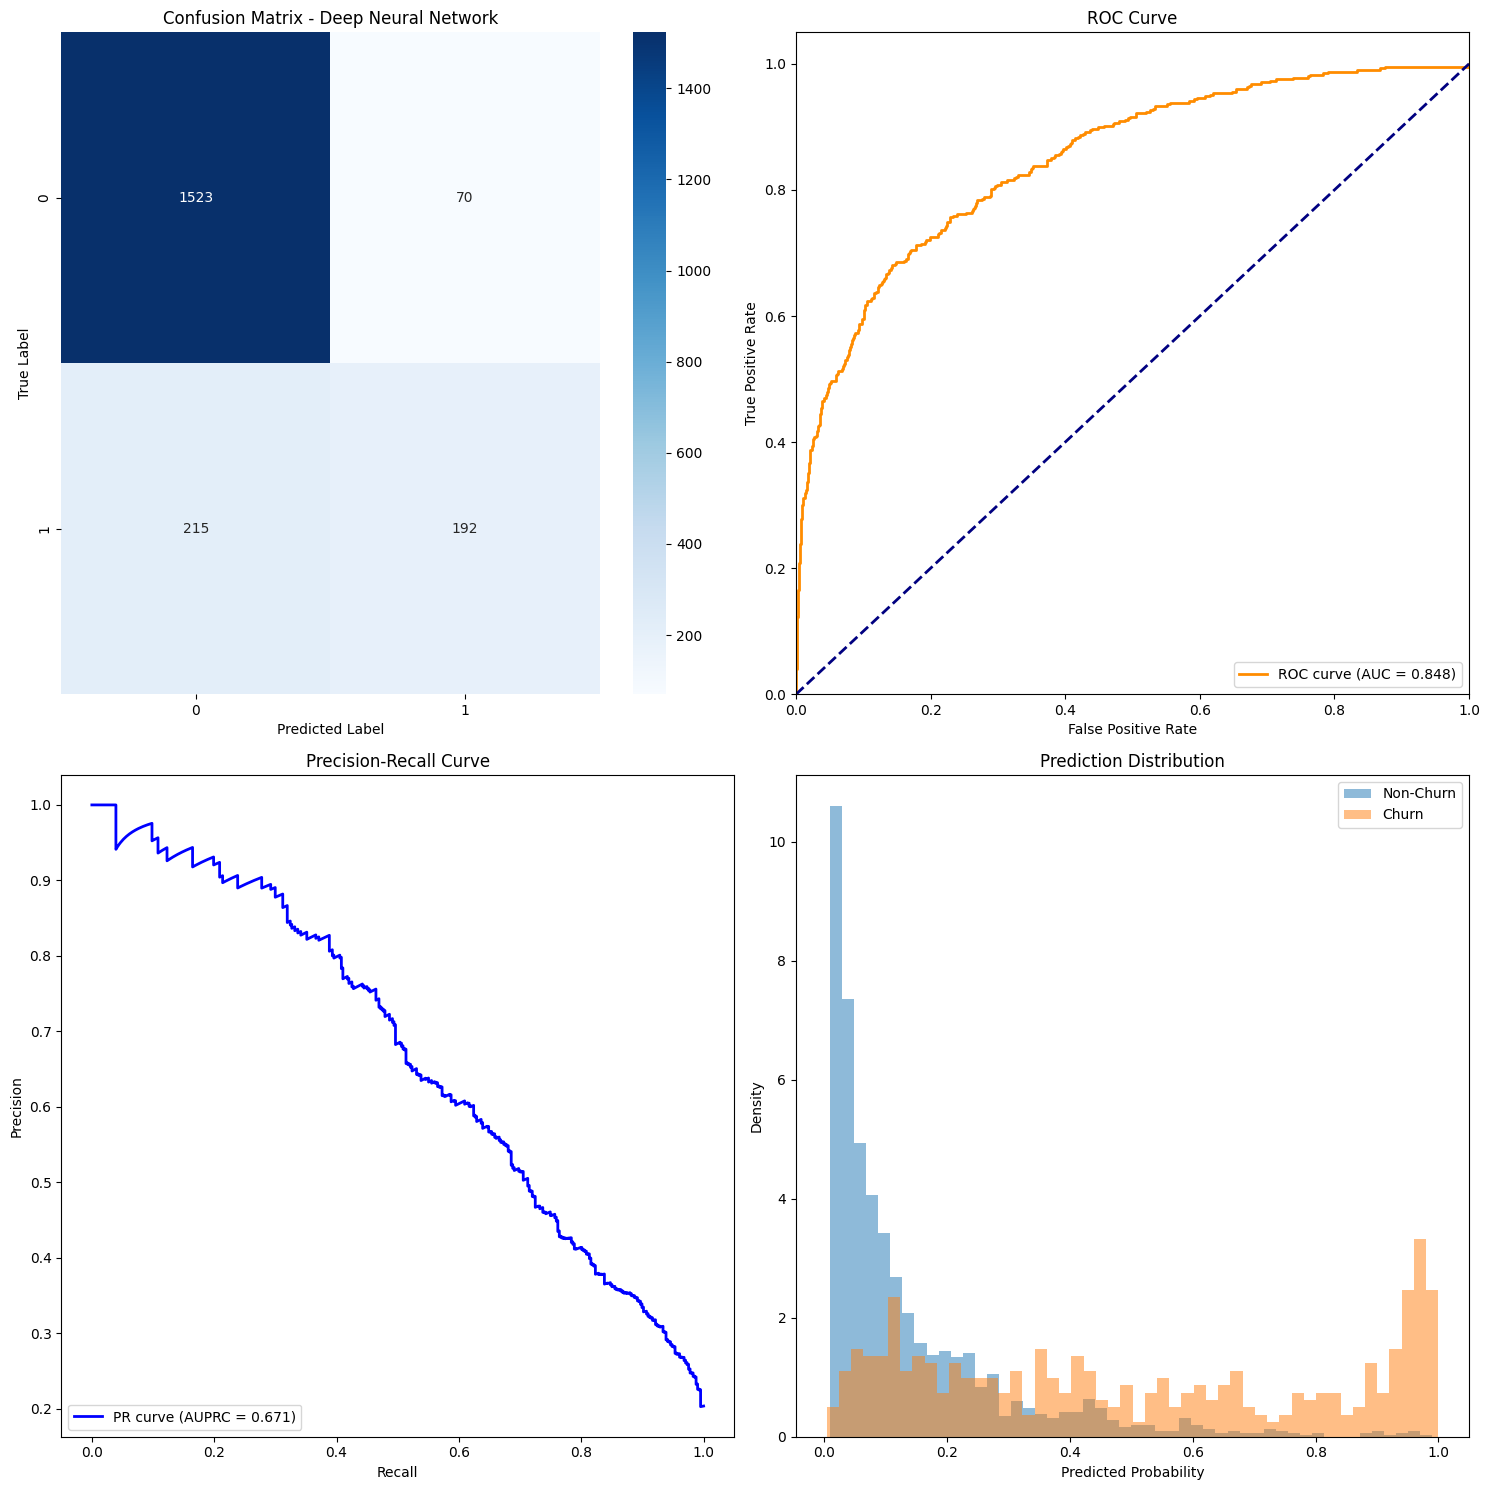

In [28]:
print("\nTraining Deep Neural Network...")
improved_nn = create_improved_neural_network((X_train_scaled.shape[1],))
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = improved_nn.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate Neural Network
y_pred_nn = improved_nn.predict(X_test_scaled)
nn_metrics = evaluate_model(y_test, y_pred_nn, y_pred_nn, "Deep Neural Network")
results.append({
    'Model': 'Deep Neural Network',
    **nn_metrics
})


#### 6.3 Train and Evaluate Improved Random Forest


Training Improved Random Forest...
Use /tmp/tmpr74ky4pd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.355979. Found 12740 examples.
Training model...


[INFO 24-12-01 04:58:48.9406 UTC kernel.cc:1233] Loading model from path /tmp/tmpr74ky4pd/model/ with prefix bc4441fca4964685


Model trained in 0:00:12.546889
Compiling model...


[INFO 24-12-01 04:58:52.2566 UTC decision_forest.cc:734] Model loaded with 500 root(s), 740154 node(s), and 12 input feature(s).
[INFO 24-12-01 04:58:52.2566 UTC abstract_model.cc:1362] Engine "RandomForestOptPred" built
[INFO 24-12-01 04:58:52.2567 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
2/2 [==============================] - 0s 84ms/step

=== Improved Random Forest Performance ===
Accuracy: 0.850
F1 Score: 0.617
ROC AUC: 0.846
AUPRC: 0.674

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1593
           1       0.64      0.59      0.62       407

    accuracy                           0.85      2000
   macro avg       0.77      0.75      0.76      2000
weighted avg       0.85      0.85      0.85      2000



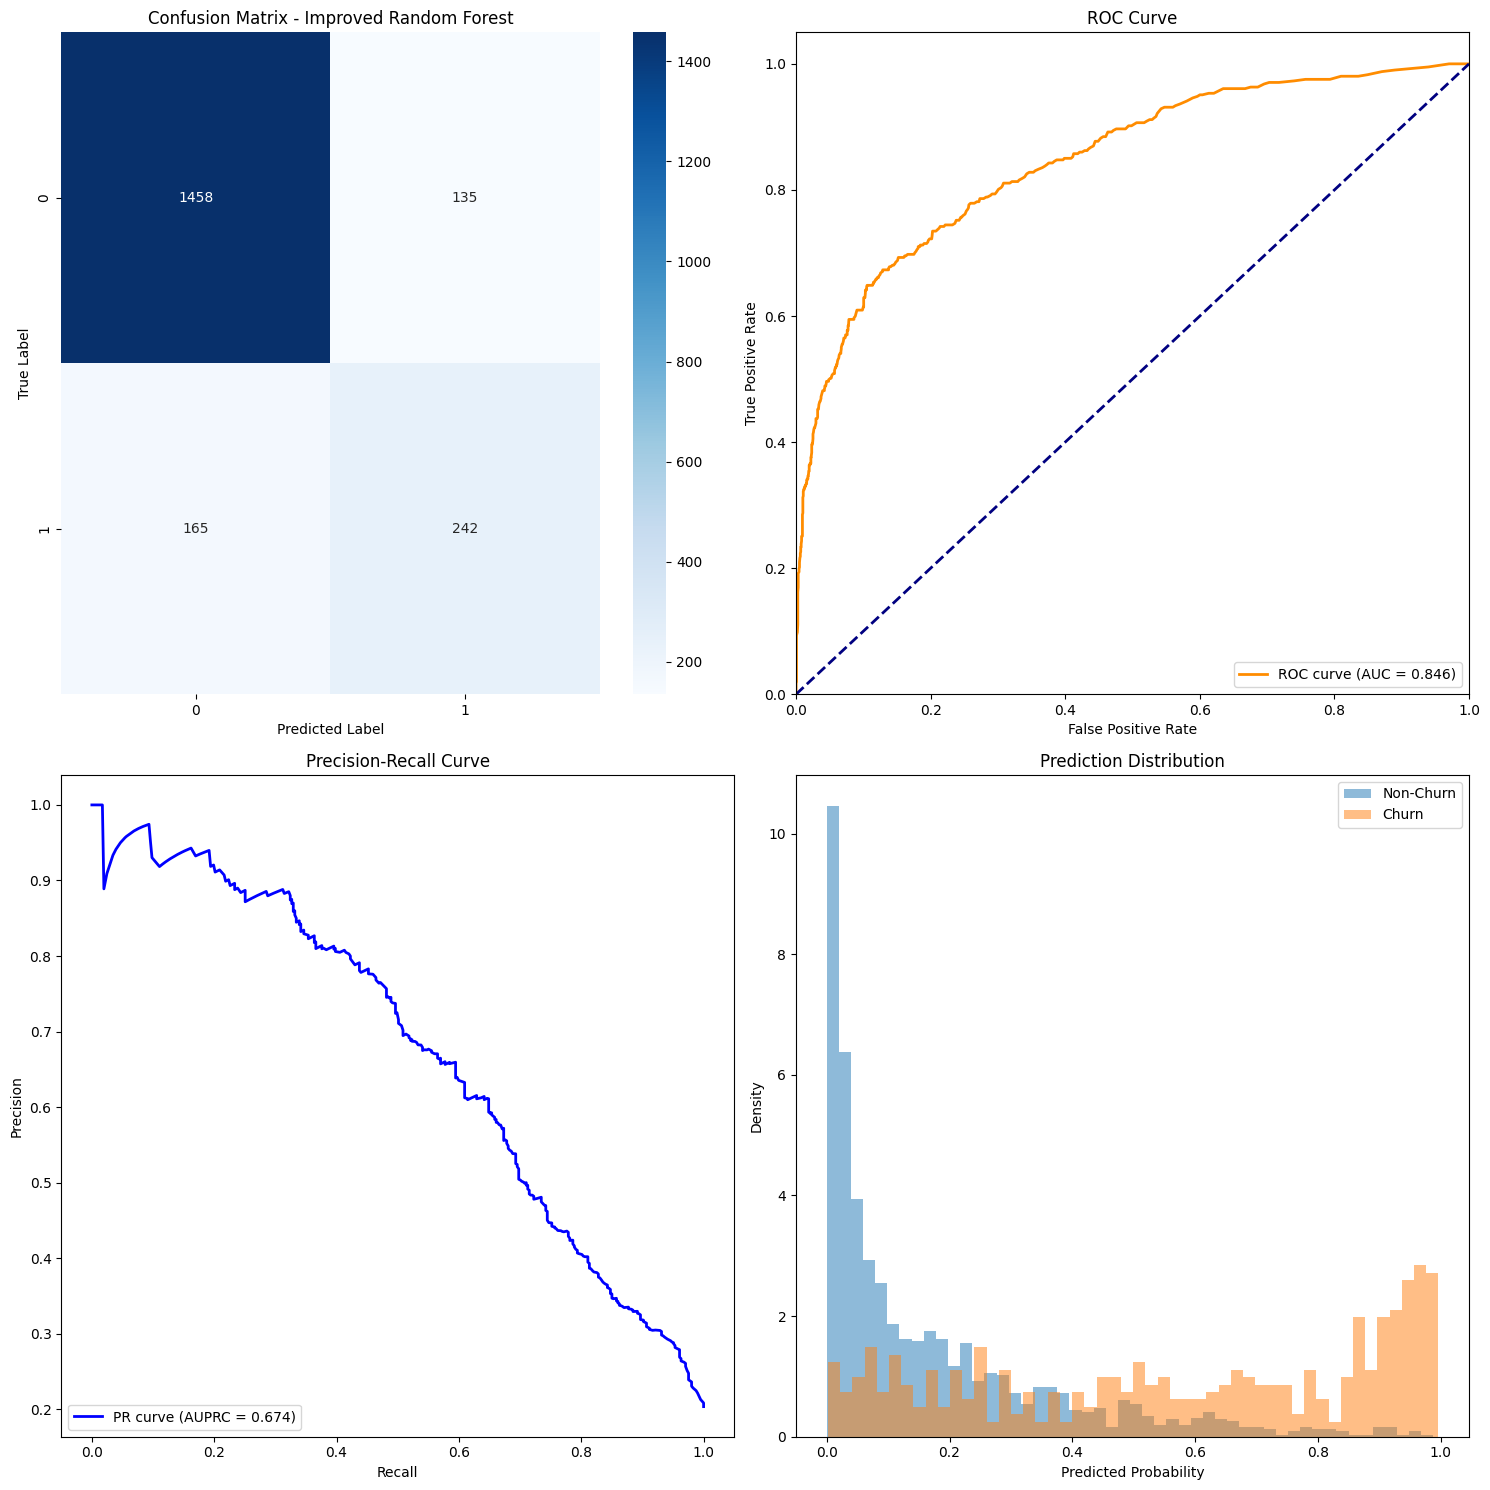

In [29]:
print("\nTraining Improved Random Forest...")
random_forest_improved = tfdf.keras.RandomForestModel(
    num_trees=500,
    bootstrap_size_ratio=1.0,
    categorical_algorithm='RANDOM',
    max_depth=20
)
random_forest_improved.fit(train_ds)

# Evaluate Random Forest
y_pred_rf = random_forest_improved.predict(test_ds)
rf_metrics = evaluate_model(y_test, y_pred_rf, y_pred_rf, "Improved Random Forest")
results.append({
    'Model': 'Improved Random Forest',
    **rf_metrics
})

#### 6.4 Train and Evaluate Improved SVM with Grid Search


Performing Grid Search for SVM...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best SVM Parameters:
{'C': 100, 'gamma': 'scale', 'kernel': 'poly'}

=== Improved SVM Performance ===
Accuracy: 0.856
F1 Score: 0.530
ROC AUC: 0.816
AUPRC: 0.659

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1593
           1       0.78      0.40      0.53       407

    accuracy                           0.86      2000
   macro avg       0.82      0.69      0.72      2000
weighted avg       0.85      0.86      0.84      2000



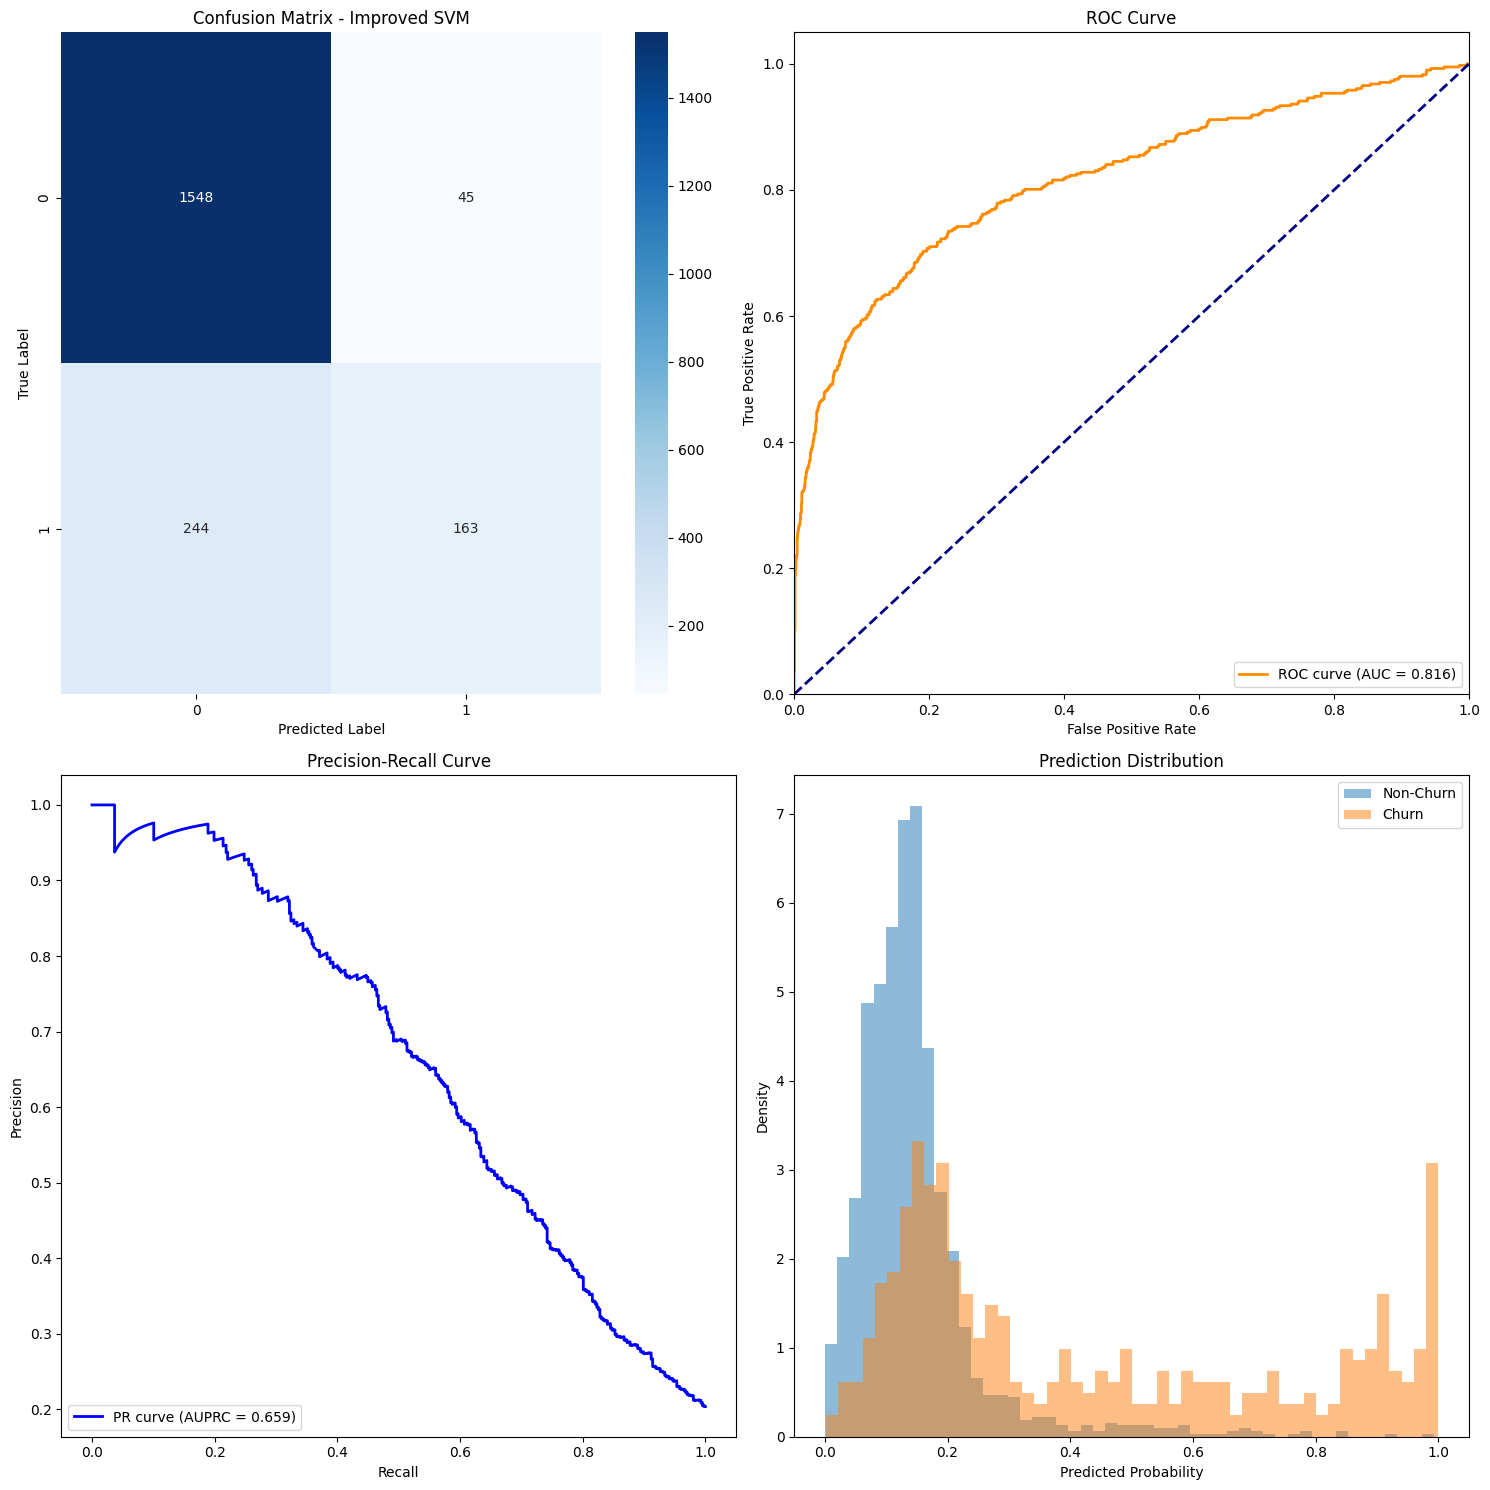

In [30]:
from sklearn.model_selection import GridSearchCV
print("\nPerforming Grid Search for SVM...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'kernel': ['rbf', 'poly']
}

grid_search = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=10
)
grid_search.fit(X_train_scaled, y_train)
best_svm = grid_search.best_estimator_

# Print best parameters
print("\nBest SVM Parameters:")
print(grid_search.best_params_)

# Evaluate SVM
y_pred_svm = best_svm.predict(X_test_scaled)
y_pred_svm_proba = best_svm.predict_proba(X_test_scaled)[:, 1]
svm_metrics = evaluate_model(y_test, y_pred_svm, y_pred_svm_proba, "Improved SVM")
results.append({
    'Model': 'Improved SVM',
    **svm_metrics
})

#### 6.5 Ensemble Predictions


Creating Ensemble Predictions...
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 [==============================] - 0s 86ms/step

=== Ensemble Model Performance ===
Accuracy: 0.863
F1 Score: 0.575
ROC AUC: 0.855
AUPRC: 0.699

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.78      0.45      0.57       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000



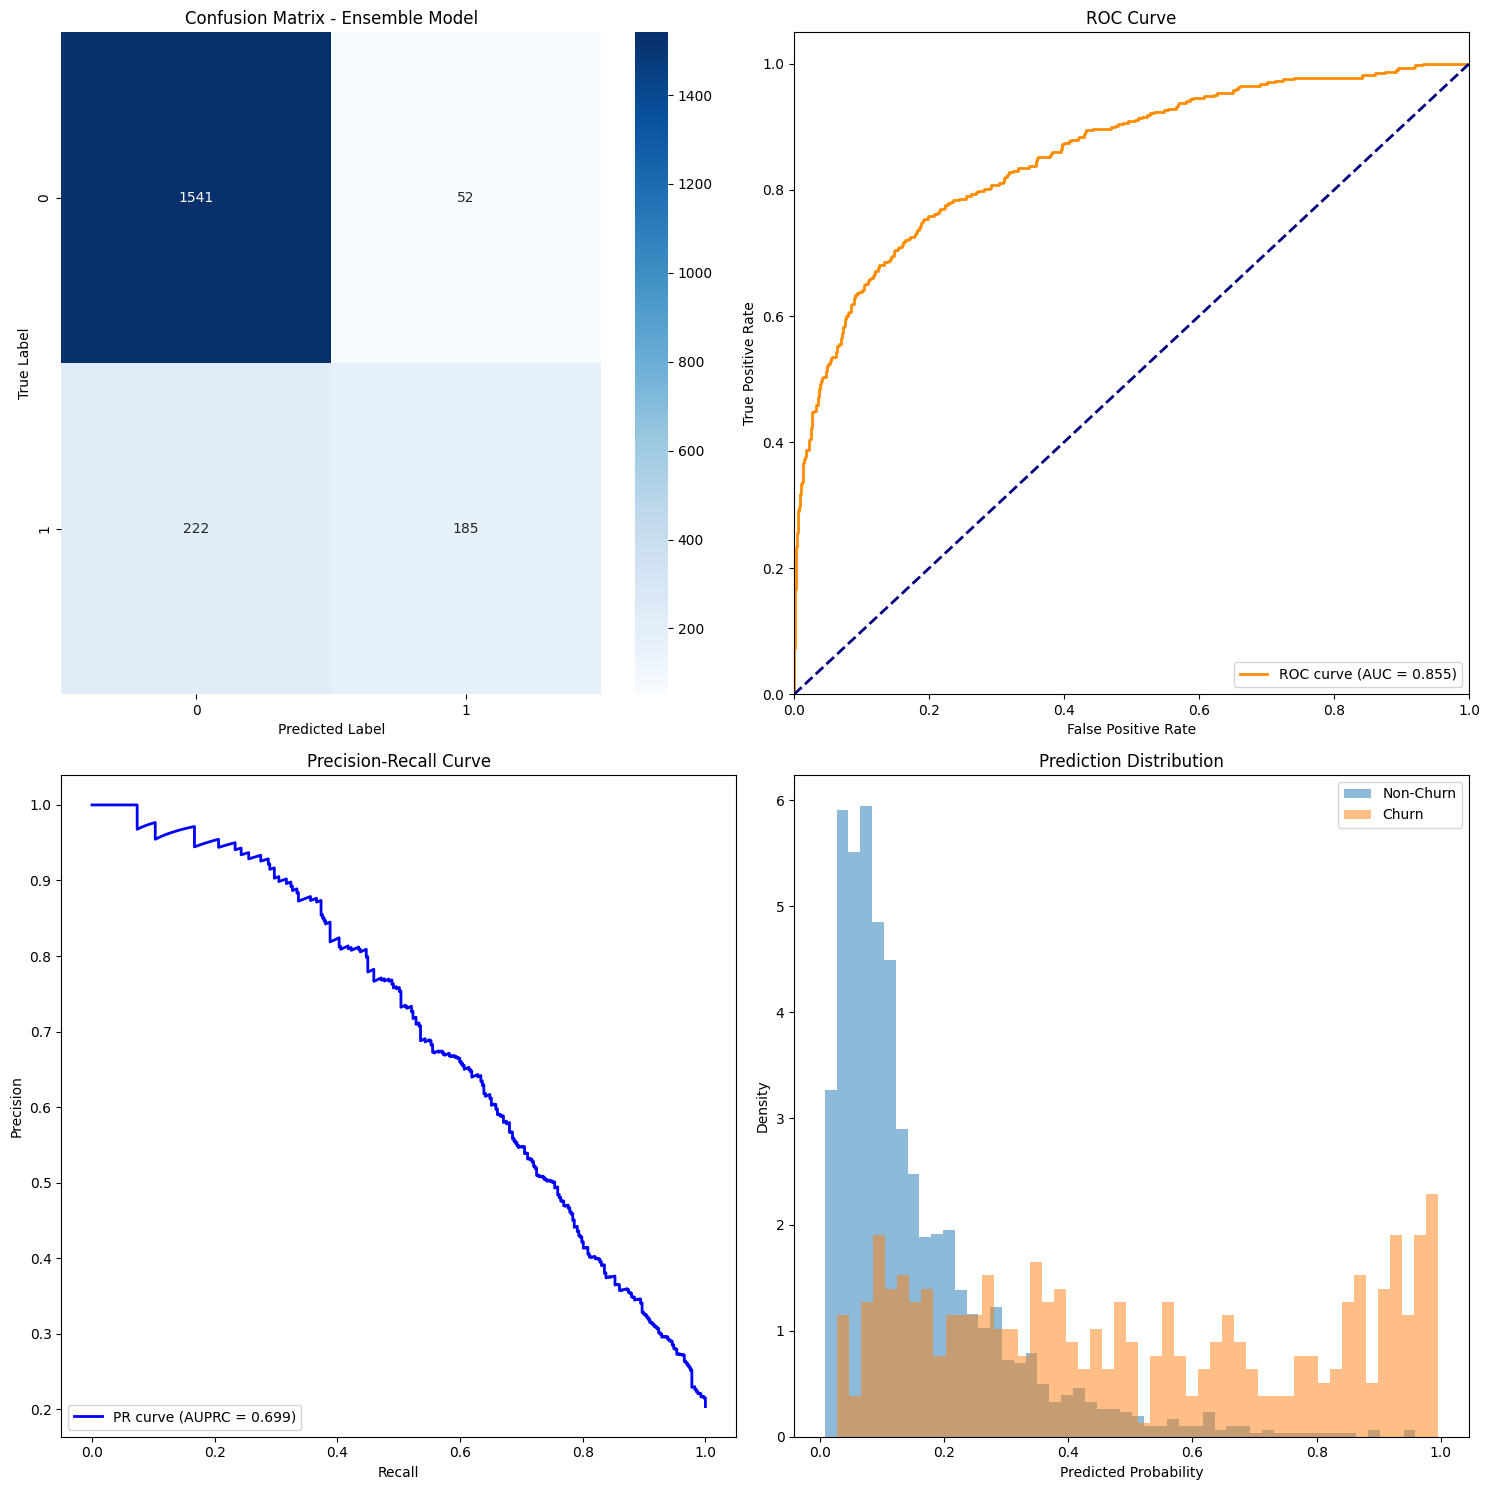

In [31]:
print("\nCreating Ensemble Predictions...")
models = [improved_nn, random_forest_improved, best_svm]
ensemble_prob = np.mean([
    improved_nn.predict(X_test_scaled).ravel(),
    random_forest_improved.predict(test_ds).ravel(),
    best_svm.predict_proba(X_test_scaled)[:, 1]
], axis=0)
ensemble_pred = (ensemble_prob > 0.5).astype(int)

ensemble_metrics = evaluate_model(y_test, ensemble_pred, ensemble_prob, "Ensemble Model")
results.append({
    'Model': 'Ensemble',
    **ensemble_metrics
})


#### 6.6 Final Model Comparison


Final Model Comparison:
                 Model  accuracy       f1  roc_auc    auprc
        Neural Network    0.8265 0.606129 0.843164 0.679286
         Random Forest    0.8490 0.626238 0.847522 0.670577
                   SVM    0.7870 0.580709 0.828723 0.628656
   Deep Neural Network    0.8575 0.573991 0.847637 0.670506
Improved Random Forest    0.8500 0.617347 0.846336 0.674472
          Improved SVM    0.8555 0.530081 0.816269 0.658964
              Ensemble    0.8630 0.574534 0.855373 0.699319


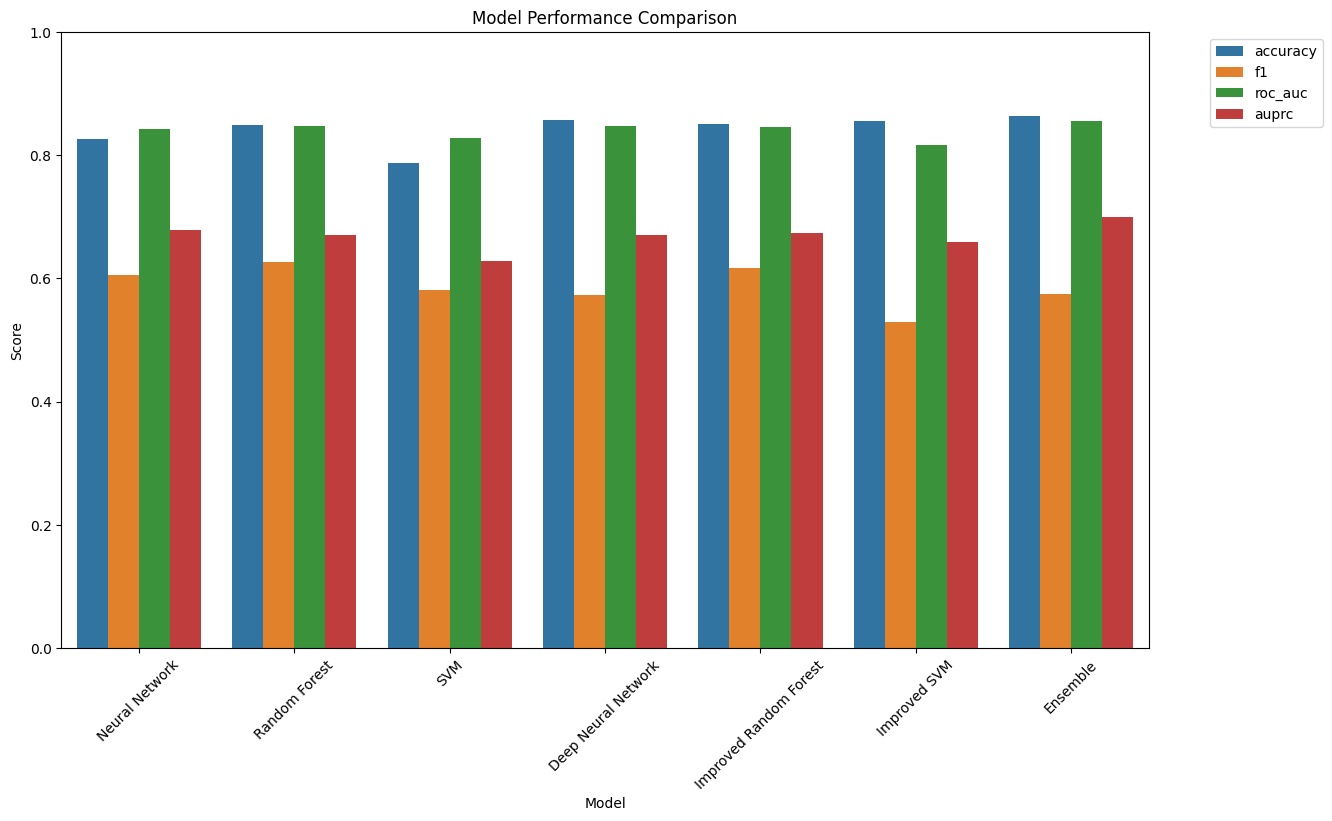


Best Model by Metric:
Best accuracy: Ensemble (0.863)
Best f1: Random Forest (0.626)
Best roc_auc: Ensemble (0.855)
Best auprc: Ensemble (0.699)


In [32]:
print("\nFinal Model Comparison:")
comparison_df = pd.DataFrame(results)
print(comparison_df.to_string(index=False))

# Plot final comparison
plt.figure(figsize=(15, 8))
metrics = ['accuracy', 'f1', 'roc_auc', 'auprc']
comparison_melted = comparison_df.melt(
    id_vars=['Model'], 
    value_vars=metrics,
    var_name='Metric',
    value_name='Score'
)

# Create comparison plot
sns.barplot(data=comparison_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(right=0.85)
plt.show()

# Print best model for each metric
print("\nBest Model by Metric:")
for metric in metrics:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, 'Model']
    best_score = comparison_df.loc[best_idx, metric]
    print(f"Best {metric}: {best_model} ({best_score:.3f})")